## Initialization

In [2]:
%matplotlib widget
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

def time_to_ss(arr):
    deriv = np.gradient(arr)
    loc = np.argmax(deriv>-0.01)
    return loc 


### Degradation Model 1: The Null Hypothesis
##### RNA is degraded on the reporter via RNAse A/T1, and the degradation rate is solely dependent on [RNA:reporter] and [RNAse A]

#### Diagram for original hypothesis:
#### Reaction Network:
$$[T][RNAP] \underset{}{\stackrel{k_p}{\longrightarrow}} [T][S][RNAP] \\
[S][R] \underset{}{\stackrel{k_{bind}}{\longrightarrow}} [S:R] \\
[S][RNAse] \underset{}{\stackrel{k_{Dss}}{\longrightarrow}} [RNAse] \\
[S:R][RNAse] \underset{}{\stackrel{k_{Dds}}{\longrightarrow}} [RNAse] \\ $$



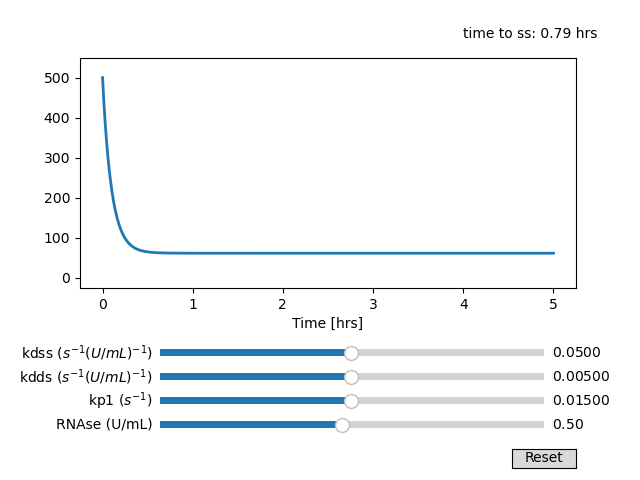

In [5]:
def degm_v1(t,x, p1,p2,p3,p4):
    '''v1: RNA is linearly degraded off the reporter'''
    T, RNA, Repoff, Repon, RNAse = x[0], x[1], x[2], x[3], x[4]
    Kp, kb,kdss,kdds = p1,p2, p3, p4
    Tdt = 0
    RNAdt = Kp*T - kb*RNA*Repoff - kdss*RNA*RNAse
    Repoffdt = -kb*RNA*Repoff + kdds*Repon*RNAse
    Repondt = -Repoffdt
    RNAsedt = 0
    return np.stack([Tdt, RNAdt, Repoffdt, Repondt, RNAsedt]).T

def degm_v1_run(xdata,kp1,kb,kd1ss,kd1ds,RNAse):
    p = [kp1,kb, kd1ss,kd1ds]#,kd2ss,kd2ds]
    Tc = 25
    Rc = 500
    RNA = 0
    cs = [Tc, RNA, 0,Rc, RNAse]
    concs = solve_ivp(degm_v1,[xdata1[0],xdata1[-1]],cs, 
                      method = 'LSODA',args=(p),t_eval=xdata1)
    creal = concs.y.T
    i = 3
    norm_Q = creal[:,i]#/Rc   
    return norm_Q

kp1 = 0.015 #s^-1
kb = 4e-5 #nM^-1*s-1
kd1ss = 5e-2 #s^-1(U/mL)^-1
kd1ds = 5e-3 #s^-1(U/mL)^-1
xdata = np.linspace(0,5,1000)
xdata1 = xdata*3600
RNAse = 0.5
Tc = 25
# Create the figure and the line that we will manipulate
fig1, ax1 = plt.subplots()
r1 = degm_v1_run(xdata1,kp1,kb,kd1ss,kd1ds,0.5)
line, = plt.plot(xdata, r1, lw=2)
tss = np.round(xdata[time_to_ss(r1)],2)
text = ax1.text(4,600,'time to ss: ' + str(tss)+ ' hrs')

ax1.set_xlabel('Time [hrs]')
ax1.set_ylim([-25, 550])

# adjust the main plot to make room for the sliders
plt.subplots_adjust(bottom=0.4)

# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.25, 0.6, 0.03])
kdss_slider = Slider(
    ax=axfreq,
    label='kdss ($s^{-1}$$(U/mL)^{-1}$)',
    valmin=kd1ss/100,
    valmax=kd1ss*2,
    valinit=kd1ss,
)
axfreq = plt.axes([0.25, 0.2, 0.6, 0.03])
kdds_slider = Slider(
    ax=axfreq,
    label='kdds ($s^{-1}$$(U/mL)^{-1}$)',
    valmin=kd1ds/100,
    valmax=kd1ds*2,
    valinit=kd1ds,
)
axfreq = plt.axes([0.25, 0.15, 0.6, 0.03])
kp1_slider = Slider(
    ax=axfreq,
    label='kp1 ($s^{-1}$)',
    valmin=kp1/100,
    valmax=kp1*2,
    valinit=kp1,
)
axfreq = plt.axes([0.25, 0.1, 0.6, 0.03])
rnase_slider = Slider(
    ax=axfreq,
    label='RNAse (U/mL)',
    valmin=RNAse/10,
    valmax=RNAse*2,
    valinit=RNAse,
)

# The function to be called anytime a slider's value changes
def update1(val):
    # amp = np.log(kdss_slider.val)
    # kdss_slider.valtext.set_text(amp)
    r2 = degm_v1_run(xdata1, kp1_slider.val,kb, kdss_slider.val,kdds_slider.val,rnase_slider.val)
    line.set_ydata(r2)
    tss = np.round(xdata[time_to_ss(r2)],2)
    text.set_text('time to ss: ' + str(tss)+ ' hrs')
    fig1.canvas.draw_idle()

# register the update function with each slider
kdss_slider.on_changed(update1)
kdds_slider.on_changed(update1)
kp1_slider.on_changed(update1)
rnase_slider.on_changed(update1)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    kdss_slider.reset()
    kdds_slider.reset()
    kp1_slider.reset()
    rnase_slider.reset()
button.on_clicked(reset)


plt.show()

### Degradation Model 2: Incomplete RNAse degradation.
#####  RNA is not completely removed by degradation via RNAse, an extra step of strand-displacement is needed to completely remove incumbent RNA.

#### Diagram for original hypothesis:
#### Reaction Network:
$$[T][RNAP] \underset{}{\stackrel{k_p}{\longrightarrow}} [T][S][RNAP] \\
[S][R] \underset{}{\stackrel{k_{bind}}{\longrightarrow}} [S:R] \\
[S][RNAse] \underset{}{\stackrel{k_{Dss}}{\longrightarrow}} [RNAse] \\
[S:R][RNAse] \underset{}{\stackrel{k_{Dds}}{\longrightarrow}} [S:R^*][RNAse] \\ 
[S:R] \underset{}{\stackrel{k_{u}}{\longrightarrow}} [R] $$



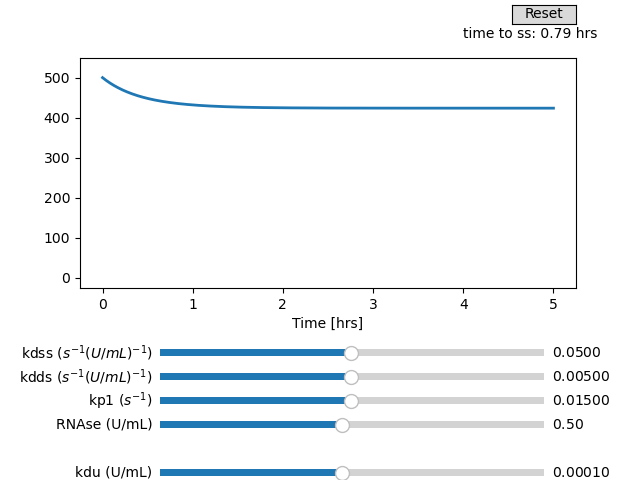

In [13]:

def degm_v2(t,x,p1,p2,p3,p4,p5):
    '''v2a: a single RNA is produced, the RNAse initiates
    degradation of the RNA off of the reporter, (to S1Rx) followed by
    hybridization to remove components of RNA stuck to the reporter.'''    
    T,S1,S1R,S1Rx,R,RNAse = x[0], x[1], x[2], x[3],x[4],x[5]
    kp1, kb, kd1ss,kd1ds,kdx = p1,p2, p3, p4, p5
    Tdt = 0
    S1dt = kp1*T - kb*S1*R - kd1ss*S1*RNAse
    S1Rdt = kb*S1*R - kd1ds*S1R*RNAse
    S1Rxdt = kd1ds*S1R*RNAse - kdx*S1Rx
    Rdt = -kb*S1*R+kdx*S1Rx
    RNAsedt = 0
    return np.stack([Tdt, S1dt, S1Rdt,S1Rxdt,Rdt,RNAsedt]).T

def degm_v2_run(xdata,kp1,kb,kd1ss,kd1ds,kdx,RNAse):
    p = [kp1,kb, kd1ss,kd1ds,kdx]#,kd2ss,kd2ds]
    Tc = 25
    Rc = 500
    RNA = 0
    cs = [Tc, RNA, 0,Rc,0, RNAse]
    concs = solve_ivp(degm_v2,[xdata1[0],xdata1[-1]],cs, 
                      method = 'LSODA',args=(p),t_eval=xdata1)
    creal = concs.y.T
    i = 4
    norm_Q = 500-creal[:,i]#/Rc   
    return norm_Q

kp1 = 0.015 #s^-1
kb = 4e-5 #nM^-1*s-1
kd1ss = 5e-2 #s^-1(U/mL)^-1
kd1ds = 5e-3 #s^-1(U/mL)^-1
kdx = 1e-4

xdata = np.linspace(0,5,1000)
xdata1 = xdata*3600
RNAse = 0.5
Tc = 25
# Create the figure and the line that we will manipulate
fig2, ax2 = plt.subplots()
r2=degm_v2_run(xdata1,kp1,kb,kd1ss,kd1ds,kdx,RNAse)
line, = plt.plot(xdata, r2, lw=2)
ax2.set_xlabel('Time [hrs]')
ax2.set_ylim([-25, 550])
tss = np.round(xdata[time_to_ss(r1)],2)
text = ax2.text(4,600,'time to ss: ' + str(tss)+ ' hrs')

# adjust the main plot to make room for the sliders
plt.subplots_adjust(bottom=0.4)

# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.25, 0.6, 0.03])
kdss_slider = Slider(
    ax=axfreq,
    label='kdss ($s^{-1}$$(U/mL)^{-1}$)',
    valmin=kd1ss/100,
    valmax=kd1ss*2,
    valinit=kd1ss,
)
axfreq = plt.axes([0.25, 0.2, 0.6, 0.03])
kdds_slider = Slider(
    ax=axfreq,
    label='kdds ($s^{-1}$$(U/mL)^{-1}$)',
    valmin=kd1ds/100,
    valmax=kd1ds*2,
    valinit=kd1ds,
)
axfreq = plt.axes([0.25, 0.15, 0.6, 0.03])
kp1_slider = Slider(
    ax=axfreq,
    label='kp1 ($s^{-1}$)',
    valmin=kp1/100,
    valmax=kp1*2,
    valinit=kp1,
)
axfreq = plt.axes([0.25, 0.1, 0.6, 0.03])
rnase_slider = Slider(
    ax=axfreq,
    label='RNAse (U/mL)',
    valmin=RNAse/10,
    valmax=RNAse*2,
    valinit=RNAse,
)
axfreq = plt.axes([0.25, 0.0, 0.6, 0.03])
kdx_slider = Slider(
    ax=axfreq,
    label='kdu (U/mL)',
    valmin=kdx/10,
    valmax=kdx*2,
    valinit=kdx,
)
# plt.legend(['$k_{Dss}$ = 0.002 $s^{-1}$','$k_{Dss}$ = 0.02 $s^{-1}$','$k_{Dss}$ = 0.2 $s^{-1}$'],loc='upper right', fontsize=fs-2)

# The function to be called anytime a slider's value changes
def update2(val):
    # amp = np.log(kdss_slider.val)
    # kdss_slider.valtext.set_text(amp)
    r2=degm_v2_run(xdata1, kp1_slider.val,kb, kdss_slider.val,kdds_slider.val,kdx_slider.val,rnase_slider.val)
    line.set_ydata(r2)
    tss = np.round(xdata[time_to_ss(r2)],2)
    text.set_text('time to ss: ' + str(tss)+ ' hrs')
    fig2.canvas.draw_idle()

# register the update function with each slider
kdss_slider.on_changed(update2)
kdds_slider.on_changed(update2)
kp1_slider.on_changed(update2)
rnase_slider.on_changed(update2)
kdx_slider.on_changed(update2)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, .95, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    kdss_slider.reset()
    kdds_slider.reset()
    kp1_slider.reset()
    rnase_slider.reset()
    kdx_slider.reset()
button.on_clicked(reset)
plt.show()

### Degradation Model 2: Two RNA populations.
#####  RNA is not completely removed by degradation via RNAse, an extra step of strand-displacement is needed to completely remove incumbent RNA.

#### Diagram for original hypothesis:
#### Reaction Network:
$$[T][RNAP] \underset{}{\stackrel{k_p}{\longrightarrow}} [T][S1][RNAP] \\
[T][RNAP] \underset{}{\stackrel{k_p}{\longrightarrow}} [T][S2][RNAP] \\
[S1][R] \underset{}{\stackrel{k_{bind1}}{\longrightarrow}} [S1:R] \\
[S2][R] \underset{}{\stackrel{k_{bind2}}{\longrightarrow}} [S2:R] \\
[S1][RNAse] \underset{}{\stackrel{k_{Dss1}}{\longrightarrow}} [RNAse] \\
[S2][RNAse] \underset{}{\stackrel{k_{Dss2}}{\longrightarrow}} [RNAse] \\
[S1:R][RNAse] \underset{}{\stackrel{k_{Dds1}}{\longrightarrow}} [R][RNAse] \\ 
[S2:R][RNAse] \underset{}{\stackrel{k_{Dds2}}{\longrightarrow}} [R][RNAse] $$


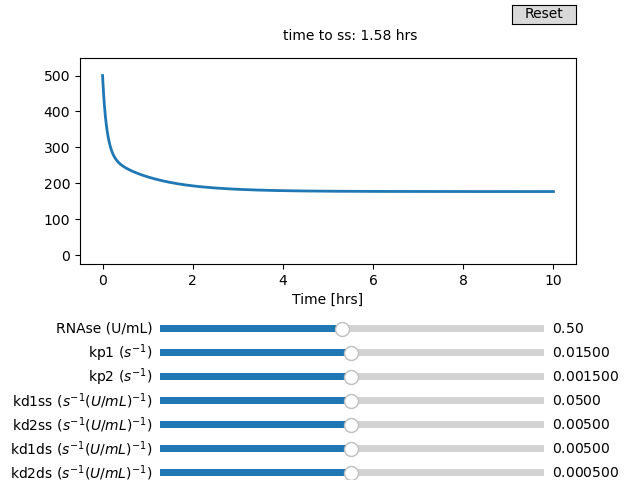

In [9]:
def degm_v3(t,x,p1,p2,p3,p4,p5,p6,p7,p8):
    '''v3: a single RNA is produced, the RNAse initiates
    degradation of the RNA off of the reporter, (to S1Rx) followed by
    hybridization to remove components of RNA stuck to the reporter.'''    
    T,S1,S2,S1R,S2R,R,RNAse = x[0], x[1], x[2], x[3],x[4],x[5],x[6]
    kp1,kp2, kb1,kb2,kd1ss,kd2ss,kd1ds,kd2ds = p1,p2, p3, p4, p5,p6,p7,p8
    Tdt = 0
    S1dt = kp1*T - kb1*S1*R - kd1ss*S1*RNAse
    S2dt = kp2*T - kb2*S2*R - kd2ss*S2*RNAse
    S1Rdt = kb1*S1*R - kd1ds*S1R*RNAse
    S2Rdt = kb2*S2*R - kd2ds*S2R*RNAse
    Rdt = -kb1*S1*R-kb2*S2*R+kd1ds*S1R*RNAse+kd2ds*S2R*RNAse
    RNAsedt = 0
    return np.stack([Tdt, S1dt,S2dt,S1Rdt,S2Rdt,Rdt,RNAsedt]).T

def degm_v3_run(xdata,kp1,kp2, kb1,kb2,kd1ss,kd2ss,kd1ds,kd2ds,RNAse):
    p = [kp1,kp2, kb1,kb2,kd1ss,kd2ss,kd1ds,kd2ds]#,kd2ss,kd2ds]
    Tc = 25
    Rc = 500
    RNA1 = 0
    RNA2 = 0
    cs = [Tc,RNA1,RNA2,Rc/2,Rc/2,0, RNAse]
    concs = solve_ivp(degm_v3,[xdata1[0],xdata1[-1]],cs, 
                      method = 'LSODA',args=(p),t_eval=xdata1)
    creal = concs.y.T
    i = 5
    norm_Q = Rc-creal[:,i]#/Rc   
    return norm_Q


kp1 = 0.015 #s^-1
kp2 = 0.0015 #s^-1 
kb1 = 4e-5 #nM^-1*s-1
kb2 = 4e-5 #nM^-1*s-1
kd1ss = 5e-2 #s^-1(U/mL)^-1
kd2ss = 5e-3 #s^-1(U/mL)^-1
kd1ds = 5e-3 #s^-1(U/mL)^-1
kd2ds = 5e-4 #s^-1(U/mL)^-1
RNAse = 0.5
Tc = 25

xdata = np.linspace(0,10,1000)
xdata1 = xdata*3600
# Create the figure and the line that we will manipulate
fig3, ax3 = plt.subplots()
r3=degm_v3_run(xdata,kp1,kp2, kb1,kb2,kd1ss,kd2ss,kd1ds,kd2ds,RNAse)
line, = plt.plot(xdata, r3, lw=2)
ax3.set_xlabel('Time [hrs]')
ax3.set_ylim([-25, 550])
tss = np.round(xdata[time_to_ss(r1)],2)
text = ax3.text(4,600,'time to ss: ' + str(tss)+ ' hrs')

# adjust the main plot to make room for the sliders
plt.subplots_adjust(bottom=0.45)

# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.3, 0.6, 0.03])
rnase_slider = Slider(
    ax=axfreq,
    label='RNAse (U/mL)',
    valmin=RNAse/10,
    valmax=RNAse*2,
    valinit=RNAse,
)
axfreq = plt.axes([0.25, 0.25, 0.6, 0.03])
kp1_slider = Slider(
    ax=axfreq,
    label='kp1 ($s^{-1}$)',
    valmin=kp1/100,
    valmax=kp1*2,
    valinit=kp1,
)
axfreq = plt.axes([0.25, 0.2, 0.6, 0.03])
kp2_slider = Slider(
    ax=axfreq,
    label='kp2 ($s^{-1}$)',
    valmin=kp2/100,
    valmax=kp2*2,
    valinit=kp2,
)
axfreq = plt.axes([0.25, 0.15, 0.6, 0.03])
kd1ss_slider = Slider(
    ax=axfreq,
    label='kd1ss ($s^{-1}$$(U/mL)^{-1}$)',
    valmin=kd1ss/100,
    valmax=kd1ss*2,
    valinit=kd1ss,
)
axfreq = plt.axes([0.25, 0.1, 0.6, 0.03])
kd2ss_slider = Slider(
    ax=axfreq,
    label='kd2ss ($s^{-1}$$(U/mL)^{-1}$)',
    valmin=kd2ss/100,
    valmax=kd2ss*2,
    valinit=kd2ss,
)

axfreq = plt.axes([0.25, 0.05, 0.6, 0.03])
kd1ds_slider = Slider(
    ax=axfreq,
    label='kd1ds ($s^{-1}$$(U/mL)^{-1}$)',
    valmin=kd1ds/100,
    valmax=kd1ds*2,
    valinit=kd1ds,
)

axfreq = plt.axes([0.25, 0.0, 0.6, 0.03])
kd2ds_slider = Slider(
    ax=axfreq,
    label='kd2ds ($s^{-1}$$(U/mL)^{-1}$)',
    valmin=kd2ds/100,
    valmax=kd2ds*2,
    valinit=kd2ds,
)

# plt.legend(['$k_{Dss}$ = 0.002 $s^{-1}$','$k_{Dss}$ = 0.02 $s^{-1}$','$k_{Dss}$ = 0.2 $s^{-1}$'],loc='upper right', fontsize=fs-2)

# The function to be called anytime a slider's value changes
def update3(val):
    # amp = np.log(kdss_slider.val)
    # kdss_slider.valtext.set_text(amp)
    r3=degm_v3_run(xdata,kp1_slider.val,kp2_slider.val, kb1, kb2,
                   kd1ss_slider.val,kd2ss_slider.val,kd1ds_slider.val,
                   kd2ds_slider.val,rnase_slider.val)
    line.set_ydata(r3)
    tss = np.round(xdata[time_to_ss(r3)],2)
    text.set_text('time to ss: ' + str(tss)+ ' hrs')
    fig3.canvas.draw_idle()

# register the update function with each slider
kp1_slider.on_changed(update3)
kp2_slider.on_changed(update3)
kd1ss_slider.on_changed(update3)
kd2ss_slider.on_changed(update3)
kd1ds_slider.on_changed(update3)
kd2ds_slider.on_changed(update3)
rnase_slider.on_changed(update3)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, .95, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    kp1_slider.reset()
    kp2_slider.reset()
    kd1ss_slider.reset()
    kd2ss_slider.reset()
    kd1ds_slider.reset()
    kd2ds_slider.reset()
    rnase_slider.reset()
button.on_clicked(reset)

plt.show()

### Degradation Model 4: Michaelis Menton Kinetics
##### RNAse A binds for a non-negligible amount of time to form a complex with the reporter:RNA, which causes load on the enzyme, changing the relationship between [RNAse A] and steady-state profiles/times

#### Diagram for original hypothesis:
#### Reaction Network:
$$[T][RNAP] \underset{}{\stackrel{k_p}{\longrightarrow}} [T][S][RNAP] \\
[S][R] \underset{}{\stackrel{k_{bind}}{\longrightarrow}} [S:R] \\
[S][RNAse] \underset{k_{bss}^-}{\stackrel{k_{bss}^+}{\rightleftharpoons}} [S:RNAse] \underset{}{\stackrel{k_{Dss}}{\longrightarrow}} [RNAse]\\
[S:R][RNAse] \underset{k_{bds}^-}{\stackrel{k_{bds}^+}{\rightleftharpoons}} [S:R:RNAse] \underset{}{\stackrel{k_{Dds}}{\longrightarrow}} [R][RNAse]\\ $$

NameError: name 'ax2' is not defined

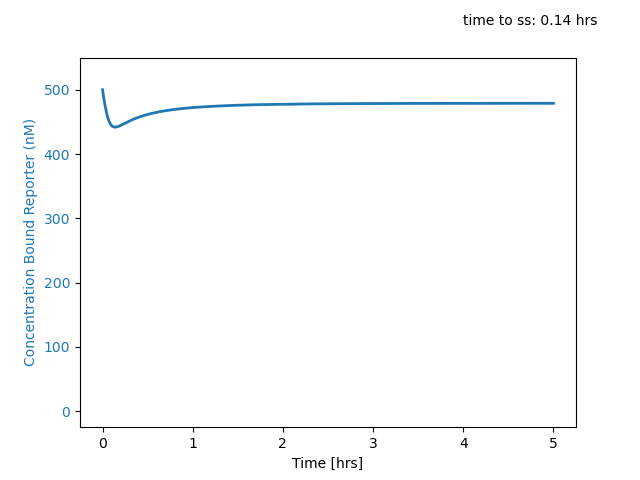

In [4]:
def degm_v4(t,x, p1,p2,p3,p4,p5,p6,p7,p8):
    '''v1: RNA is linearly degraded off the reporter'''
    T, S, R, S_R, S_RNAse, S_R_RNAse, RNAse = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    kp,kon,kbssp,kbssm,kdss,kbdsp,kbdsm,kdds = p1,p2, p3, p4,p5,p6,p7,p8
    Tdt = 0
    dSdt = kp*T-kon*S*R-kbssp*S*RNAse+kbssm*S_RNAse
    dRdt = -kon*S*R+kdds*S_R_RNAse
    dS_Rdt = kon*S*R-kbdsp*S_R*RNAse+kbdsm*S_R_RNAse
    dS_RNAsedt = kbssp*S*RNAse-kbssm*S_RNAse-kdss*S_RNAse
    dS_R_RNAsedt = kbdsp*S_R*RNAse-kbdsm*S_R_RNAse-kdds*S_R_RNAse    
    dRNAse_dt = -kbssp*S*RNAse+kbssm*S_RNAse+kdss*S_RNAse-kbdsp*S_R*RNAse+kbdsm*S_R_RNAse+kdds*S_R_RNAse 
    return np.stack([Tdt, dSdt, dRdt, dS_Rdt,dS_RNAsedt,dS_R_RNAsedt,dRNAse_dt]).T

def degm_v4_run(xdata,kp,kon,kbssp,kbssm,kdss,kbdsp,kbdsm,kdds,RNAse_c):
    p = [kp,kon,kbssp,kbssm,kdss,kbdsp,kbdsm,kdds]#,kd2ss,kd2ds]
    Tc = 25
    Sc = 0
    Rc = 0
    S_Rc = 500
    S_RNAse_c = 0
    S_R_RNAse_c = 0
    RNAse_c = RNAse_c
    cs = [Tc,Sc,Rc,S_Rc,S_RNAse_c,S_R_RNAse_c,RNAse_c]
    concs = solve_ivp(degm_v4,[xdata1[0],xdata1[-1]],cs, 
                      method = 'LSODA',args=(p),t_eval=xdata1)
    creal = concs.y.T
    R = creal[:,3]#/Rc   
    RNAse = creal[:,-1]
    return R,RNAse

color1 = 'tab:blue'
color2 = 'tab:red'
kp = 0.015 #s^-1
kon = 4e-5 #nM^-1*s-1
kbssp = 4e-2 #nM^-1*s-1
kbssm = 4e-3 #*s-1
kdss = 2.5 #s^-1(U/mL)^-1
kbdsp = 4e-2 #nM^-1*s-1
kbdsm = 4e-3 #*s-1
kdds = .25 #s^-1(U/mL)^-1
RNAse_c = 1
xdata = np.linspace(0,5,1000)
xdata1 = xdata*3600
# Create the figure and the line that we will manipulate
fig1, ax1 = plt.subplots()
r1 = degm_v4_run(xdata1,kp,kon,kbssp,kbssm,kdss,kbdsp,kbdsm,kdds,RNAse_c)
tss = np.round(xdata[time_to_ss(r1[0])],2)
text = ax1.text(4,600,'time to ss: ' + str(tss)+ ' hrs')

ax1.set_xlabel('Time [hrs]')
ax1.set_ylabel('Concentration Bound Reporter (nM)',color=color1)
ax1.set_ylim([-25, 550])
line1, = plt.plot(xdata, r1[0], lw=2,color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax2.tick_params(axis='y', labelcolor=color2)

ax2 = ax1.twinx()
ax2.set_ylabel('Concentration Free RNAse (U/mL)', color=color2)
line2, = plt.plot(xdata, r1[1], lw=2,color=color2)
ax2.set_ylim([-.5, 15])
fig1.tight_layout()
# adjust the main plot to make room for the sliders
plt.subplots_adjust(bottom=0.45)

# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.3, 0.6, 0.03])
#stopped here:
    
kdss_slider = Slider(
    ax=axfreq,
    label='kdss ($s^{-1}$$(U/mL)^{-1}$)',
    valmin=kdss/100,
    valmax=kdss*2,
    valinit=kdss,
)
axfreq = plt.axes([0.25, 0.25, 0.6, 0.03])
kdds_slider = Slider(
    ax=axfreq,
    label='kdds ($s^{-1}$$(U/mL)^{-1}$)',
    valmin=kdds/100,
    valmax=kdds*2,
    valinit=kdds,
)
axfreq = plt.axes([0.25, 0.2, 0.6, 0.03])
kp_slider = Slider(
    ax=axfreq,
    label='kp ($s^{-1}$)',
    valmin=kp/100,
    valmax=kp*2,
    valinit=kp,
)
axfreq = plt.axes([0.25, 0.15, 0.6, 0.03])
rnase_slider = Slider(
    ax=axfreq,
    label='RNAse (U/mL)',
    valmin=RNAse_c/5,
    valmax=RNAse_c*5,
    valinit=RNAse_c,
)
axfreq = plt.axes([0.25, 0.1, 0.6, 0.03])
kbdsp_slider = Slider(
    ax=axfreq,
    label='$kbds^{+}$$(nM)^{-1}$$s^{-1}$',
    valmin=kbdsp/4,
    valmax=kbdsp*2,
    valinit=kbdsp,
)
axfreq = plt.axes([0.25, 0.05, 0.6, 0.03])
kbdsm_slider = Slider(
    ax=axfreq,
    label='$kbds^{-}$$(nM)^{-1}$$s^{-1}$',
    valmin=kbdsm/4,
    valmax=kbdsm*2,
    valinit=kbdsm,
)

# The function to be called anytime a slider's value changes
def update4(val):
    # amp = np.log(kdss_slider.val)
    # kdss_slider.valtext.set_text(amp)
    r2 = degm_v4_run(xdata1, kp_slider.val,kon,kbssp,kbssm,kdss_slider.val,kbdsp_slider.val,kbdsm_slider.val,kdds_slider.val,rnase_slider.val)
    line1.set_ydata(r2[0])
    line2.set_ydata(r2[1])
    tss = np.round(xdata[time_to_ss(r2[0])],2)
    text.set_text('time to ss: ' + str(tss)+ ' hrs')
    fig1.canvas.draw_idle()

# register the update function with each slider
kdss_slider.on_changed(update4)
kdds_slider.on_changed(update4)
kp_slider.on_changed(update4)
rnase_slider.on_changed(update4)
kbdsp_slider.on_changed(update4)
kbdsm_slider.on_changed(update4)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, .95, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    kdss_slider.reset()
    kdds_slider.reset()
    kp1_slider.reset()
    rnase_slider.reset()
button.on_clicked(reset)

plt.show()